In [1]:
import pandas as pd
import numpy as np
data=pd.read_csv('/mnt/amazon_product_data/ratings_Books.csv',header=None)

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [2]:
data.columns=['asin','user_id','rating','time']

In [4]:
counted_users=data.groupby('user_id').count()

In [5]:
counted_users.columns=['count', 'rating', 'time']

In [6]:
counted_asin=data.groupby('asin').count()

In [7]:
counted_asin.columns=['count', 'rating', 'time']

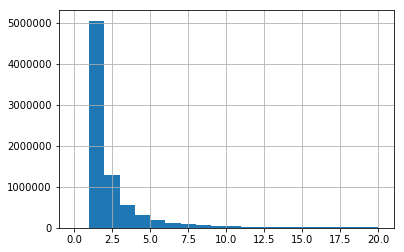

In [8]:
%matplotlib inline
counted_asin['count'].hist(bins=20,range=[0,20])

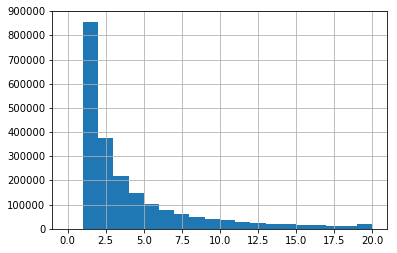

In [9]:
counted_users['count'].hist(bins=20,range=[0,20])

In [10]:
filtered_users=counted_users.sort_values('count',ascending=False).head(20000)
filtered_asin=counted_asin.sort_values('count',ascending=False).head(20000)

In [11]:
data.head()

,asin,user_id,rating,time
0,AH2L9G3DQHHAJ,0000000116,4.0,1019865600
1,A2IIIDRK3PRRZY,0000000116,1.0,1395619200
2,A1TADCM7YWPQ8M,0000000868,4.0,1031702400
3,AWGH7V0BDOJKB,0000013714,4.0,1383177600
4,A3UTQPQPM4TQO0,0000013714,5.0,1374883200


In [12]:
np.sum(data.user_id.isin(filtered_users.index.values))

7131304

In [13]:
np.sum(data.asin.isin(filtered_asin.index.values))

3429446

In [14]:
data_filtered=data[(data.user_id.isin(filtered_users.index.values)) & (data.asin.isin(filtered_asin.index.values))]

In [15]:
len(data_filtered),len(data_filtered.asin.unique()),len(data_filtered.user_id.unique())

(846441, 19617, 19811)

In [16]:
846441/(19617*19811)

0.002177999128003709

In [17]:
#gidi
userId = data_filtered.user_id.unique()
asin = data_filtered.asin.unique()

In [18]:
#gidi
user_id2idx = {o:i for i,o in enumerate(userId)}
asin2idx = {o:i for i,o in enumerate(asin)}

In [19]:
idx2asin = {i:o for i,o in enumerate(asin)}

In [20]:
asin

array(['A2S166WSCFIFP5', 'A2XQ5LZHTD4AFT', 'A1NPNGWBVD9AK3', ...,
       'A8HID0WMOH1NQ', 'A2UWL4KXZDKRL', 'A28CWPKNUAF71D'], dtype=object)

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [21]:
#ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
#ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [22]:
#gidi
#conversion of filtered data to numbers (label encoding)
data_filtered.asin = data_filtered.asin.apply(lambda x: asin2idx[x])
data_filtered.user_id = data_filtered.user_id.apply(lambda x: user_id2idx[x])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [23]:
n_users = data_filtered.user_id.nunique()
n_asin = data_filtered.asin.nunique()
n_users, n_asin

(19811, 19617)

This is the number of latent factors in each embedding.

In [24]:
n_factors = 50

Randomly split into training and validation.

In [25]:
#msk = np.random.rand(len(half_data)) < 0.8
#trn = half_data[msk]
#val = half_data[~msk]

In [26]:
#start=50; end=100
#X = fac0[start:end]
#Y = fac2[start:end]
#plt.figure(figsize=(15,15))
#plt.scatter(X, Y)
#for i, x, y in zip(topMovies[start:end], X, Y):
#    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
#plt.show()

## LightFM

In [27]:
import lightfm
from lightfm.evaluation import auc_score
import scipy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [28]:
alpha = 1e-3
epochs = 70

model = lightfm.LightFM(no_components=30,loss='warp',learning_schedule='adagrad',user_alpha=alpha,
                        item_alpha=alpha)


In [29]:
sparse_mat=scipy.sparse.csr_matrix((np.ones(len(data_filtered)), (data_filtered['user_id'].values, data_filtered['asin'].values)))

In [30]:
#model.fit(sparse_mat,epochs=3)
model.fit(sparse_mat, epochs=30)

In [31]:
sparse_mat

<19811x19617 sparse matrix of type '<class 'numpy.float64'>'
	with 846441 stored elements in Compressed Sparse Row format>

In [32]:
top_asin=[idx2asin[i] for i in range(19617)]

In [33]:
idx2asin[0]

'A2S166WSCFIFP5'

In [59]:
auc_score(model, sparse_mat, num_threads=8).mean()

0.71549505

In [61]:
vecs=model.item_embeddings

In [56]:
from sklearn.manifold import TSNE

In [127]:
len(top_asin),top_asin[0]

(19617, 'A2S166WSCFIFP5')

In [132]:
asin2title

{'0001048791': 'The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast'}

In [60]:
titles=[asin2title[asin] for asin in top_asin]

KeyError: 'A2S166WSCFIFP5'

In [72]:
titles=[]
i=0
for asin in top_asin:
    try:
        
        titles.append(asin2title[asin])
        i+=1
    except:
        titles.append(asin)

In [74]:
asin2title

{'0001048791': 'The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast',
 '0000143561': 'Everyday Italian (with Giada de Laurentiis), Volume 1 (3 Pack): Italian Classics, Parties, Holidays',
 '0000037214': 'Purple Sequin Tiny Dancer Tutu Ballet Dance Fairy Princess Costume Accessory',
 '0000032069': 'Adult Ballet Tutu Cheetah Pink',
 '0000031909': 'Girls Ballet Tutu Neon Pink',
 '0000032034': 'Adult Ballet Tutu Yellow',
 '0001048775': 'Measure for Measure: Complete &amp; Unabridged',
 '0000031852': 'Girls Ballet Tutu Zebra Hot Pink',
 '0001048813': 'Archer Christmas 4 Tape Pack',
 '0001148427': 'Sonatas - For Piano',
 '0001047566': 'Hand in Glove',
 '0001053396': 'War Poems: An Anthology of Poetry from the 18th Cantury to the Present Day',
 '0000913154': 'The Way Things Work: An Illustrated Encyclopedia of Technology',
 '0000032050': 'Adult Ballet Tutu Purple',
 '0001072986': 'As You Like it: Complete &amp; Unabridged',
 '0001064487': 'Celebremos Su Gloria',
 '0001042335':

In [75]:
i

0

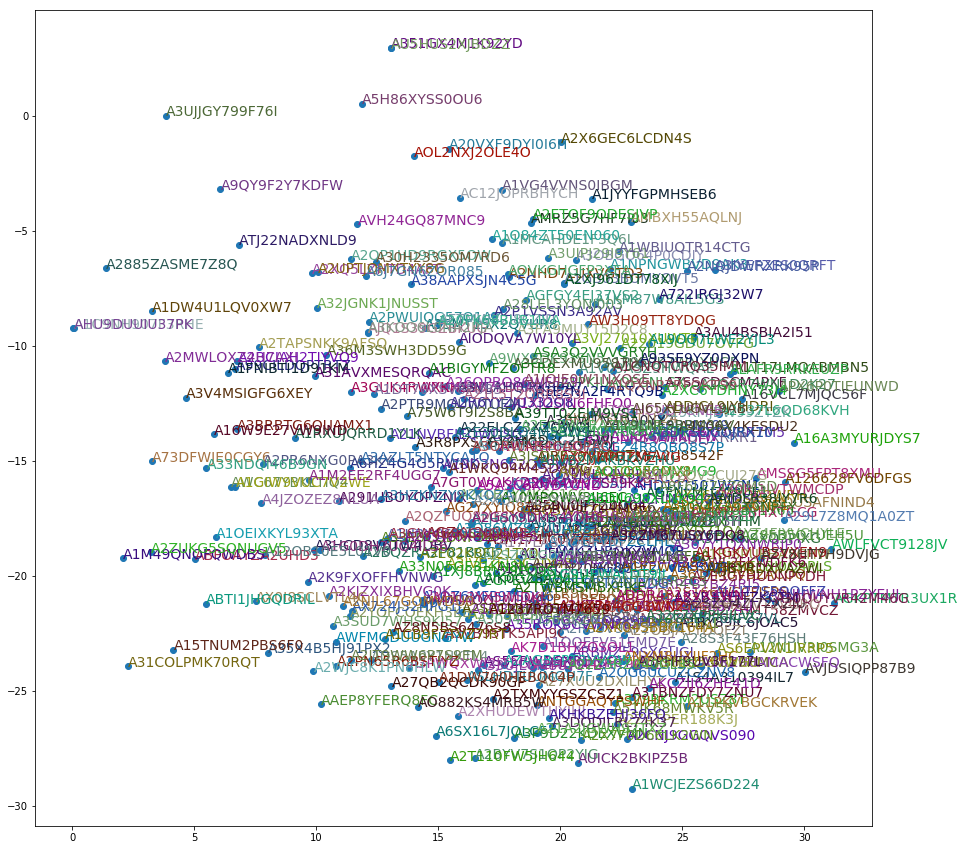

In [62]:
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(vecs[:500])

start=0; end=350
dat = Y[start:end]
plt.figure(figsize=(15,15))
plt.scatter(dat[:, 0], dat[:, 1])
for label, x, y in zip(titles[start:end], dat[:, 0], dat[:, 1]):
    plt.text(x,y,label, color=np.random.rand(3)*0.7,fontsize=14)
    
plt.show()

## asin dict

In [35]:
cd /mnt/amazon_product_data/

/mnt/amazon_product_data


In [36]:
with open('metadata.json') as f:
    content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 

In [76]:
content[0].replace("'", '"')

'{"asin": "0001048791", "salesRank": {"Books": 6334800}, "imUrl": "http://ecx.images-amazon.com/images/I/51MKP0T4DBL.jpg", "categories": [["Books"]], "title": "The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast"}'

In [146]:
len(content_parsed)

6028635

In [148]:
content_parsed[0]

{'asin': '0001048791',
 'categories': [['Books']],
 'imUrl': 'http://ecx.images-amazon.com/images/I/51MKP0T4DBL.jpg',
 'salesRank': {'Books': 6334800},
 'title': 'The Crucible: Performed by Stuart Pankin, Jerome Dempsey &amp; Cast'}

In [47]:
import json
content_parsed=[]
for element in content:
    try:
        content_parsed.append(json.loads(element.replace("'", '"')))
    except:
        pass

In [70]:
asin2title={}
for i in range(len(content_parsed)):
    try:
        asin2title[content_parsed[i]['asin']]=content_parsed[i]['title']
    except:
        try:
            asin2title[content_parsed[i]['asin']]='unknown'
        except:
            pass#print('error in',content_parsed[i])
        pass#print('error in',content_parsed[i])


In [81]:
list(asin2title.keys())[:100]

['0001048791',
 '0000143561',
 '0000037214',
 '0000032069',
 '0000031909',
 '0000032034',
 '0001048775',
 '0000031852',
 '0001048813',
 '0001148427',
 '0001047566',
 '0001053396',
 '0000913154',
 '0000032050',
 '0001072986',
 '0001064487',
 '0001042335',
 '0000202010',
 '0001057138',
 '0000000868',
 '0000695009',
 '0001053655',
 '0000038504',
 '0001061100',
 '000107461X',
 '0000143529',
 '0000477141',
 '0001437879',
 '0001035649',
 '0001381245',
 '0001468685',
 '0000031887',
 '0001473727',
 '0001061127',
 '0001384198',
 '0000230022',
 '0000031895',
 '0001382489',
 '0001001787',
 '0000174076',
 '0000000116',
 '0000013714',
 '0001380877',
 '0001486632',
 '0001484648',
 '0001057146',
 '0001360183',
 '0001517791',
 '0001006002',
 '0001632108',
 '0001436163',
 '0001527665',
 '0001713086',
 '0001361155',
 '0001472933',
 '000171130X',
 '0001361139',
 '0001062395',
 '0001473905',
 '000047715X',
 '0001386301',
 '0001536338',
 '0001720104',
 '0001516035',
 '0001621076',
 '0001501348',
 '00013841

### cross asin from data and meta

In [83]:
np.intersect1d(data.asin.values,list(asin2title.keys()))

KeyboardInterrupt: 

In [86]:
elce_data=pd.read_csv('ratings_Electronics.csv',header=None)